# ResNet

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil
import time
import random

from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations.pytorch import ToTensorV2
import albumentations as A

from PIL import Image
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Creation of Training and Test Datasets:**

This code performs the task of splitting a dataset into training and test sets for a classification problem. The aim of the code is to create balanced training and test datasets for each class.

*   The model is trained fairly by using the same proportion of data from each class.
*   The training and test datasets are split with an 80% and 20% ratio for each class, respectively.
*   The dataset is randomly shuffled to prevent the model from being affected by the order of the data. This helps the model generalize better.

In [ ]:
# ---- PATH ----
# Image folder path
data_dir = "/content/drive/MyDrive/GARBAGE CLASSIFICATION/dataset"

# Label csv path
file_path = "/content/drive/MyDrive/GARBAGE CLASSIFICATION/updated_all_data.csv"
df = pd.read_csv(file_path)

# ---- Creating Train/Test DataFrame ----
classes = df['label_name'].unique()

# shuffle data
df = df .sample(frac=1, random_state=42).reset_index(drop=True)

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for class_name in classes:
    class_data = df[df['label_name'] == class_name]

    train_data, test_data = train_test_split(class_data, test_size=0.2, random_state=42)

    train_df = pd.concat([train_df, train_data], ignore_index=True)
    test_df = pd.concat([test_df, test_data], ignore_index=True)

    print(f"{class_name} Eğitim Veri Seti Boyutu: {len(train_data)}")
    print(f"{class_name} Test Veri Seti Boyutu: {len(test_data)}\n")

# Train - Test Dataframes
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Toplam Eğitim Veri Seti Boyutu: {len(train_df)}")
print(f"Toplam Test Veri Seti Boyutu: {len(test_df)}")

trash Eğitim Veri Seti Boyutu: 158
trash Test Veri Seti Boyutu: 40

plastic Eğitim Veri Seti Boyutu: 937
plastic Test Veri Seti Boyutu: 235

paper Eğitim Veri Seti Boyutu: 580
paper Test Veri Seti Boyutu: 146

metal Eğitim Veri Seti Boyutu: 562
metal Test Veri Seti Boyutu: 141

glass Eğitim Veri Seti Boyutu: 866
glass Test Veri Seti Boyutu: 217

battery Eğitim Veri Seti Boyutu: 746
battery Test Veri Seti Boyutu: 187

Toplam Eğitim Veri Seti Boyutu: 3849
Toplam Test Veri Seti Boyutu: 966


**Data Preprocessing and Validation with the CustomDataset Class**

This code is designed to create a dataset suitable for model training. It verifies the correctness and validity of the data, crops bounding box regions, and enriches the data through transformations. As a result, the model is trained on a more diverse and clean dataset, which improves overall performance.

* **Data Validation:** Prevents invalid images and incorrect bounding box coordinates from causing errors during training.
* **Bounding Box Processing:** Uses only the target region (bounding box) of the image to help the model focus more effectively.
* **Albumentations Support:** Integrates with Albumentations, a powerful library for data preprocessing.
* **PyTorch Compatibility:** Creates a dataset object that can be used directly in PyTorch model training.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

        # Filter invalid samples
        self.df = self._validate_data(df)

    def _validate_data(self, df):
        valid_indices = []
        for idx, row in df.iterrows():
            # Check if image file exists
            image_path = os.path.join(self.data_dir, row['image_name'])
            if not os.path.exists(image_path):
                print(f"Uyarı: {image_path} dosyası bulunamadı.")
                continue

            # Check the bounding box coordinates
            img = Image.open(image_path)
            width, height = img.size

            x1 = max(0, row['bbox_x'])
            y1 = max(0, row['bbox_y'])
            x2 = min(width, x1 + row['bbox_width'])
            y2 = min(height, y1 + row['bbox_height'])

            # Is it a valid bounding box
            if x2 <= x1 or y2 <= y1 or x2 > width or y2 > height:
                print(f"Uyarı: {row['image_name']} için geçersiz bounding box koordinatları.")
                continue

            valid_indices.append(idx)

        return df.loc[valid_indices].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.data_dir, row['image_name'])

        # Load image as numpy array
        img = np.array(Image.open(image_path).convert('RGB'))

        # Correct the bounding box coordinates
        x1 = max(0, int(row['bbox_x']))
        y1 = max(0, int(row['bbox_y']))
        x2 = min(img.shape[1], x1 + int(row['bbox_width']))
        y2 = min(img.shape[0], y1 + int(row['bbox_height']))

        # Make sure it is at least 1x1 in size
        if x2 <= x1:
            x2 = x1 + 1
        if y2 <= y1:
            y2 = y1 + 1

        # Crop process
        img = img[y1:y2, x1:x2]

        # Apply Albumentations transform
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        # Convert to Tensor (normalization is done in Albumentations)
        img = torch.from_numpy(img.transpose(2, 0, 1)).float()

        # Get the label
        label = row['label_name']
        return img, label

**Model Training and Evaluation with PyTorch**

The ModelTrainer class simplifies the training, validation, and testing processes of a model. The training procedure is optimized with features such as early stopping and learning rate adjustment.
Developed using PyTorch, this class provides the following key features:

1. **Validation and Early Stopping**
*   The model is validated on the validation dataset after each epoch.
*   If the validation loss does not improve, training is stopped early.

2.  **Model Training**
*   The training data is split into training and validation sets.
*   The model is trained on the training data in each epoch.
*   Training loss and accuracy are monitored.
*   The learning rate is adjusted based on the validation loss.

3. **Model Evaluation**
*   After training is complete, the model is evaluated on the test dataset.
*   A Confusion Matrix and Classification Report are generated.
*   The F1 Score is calculated.

In [ ]:
class ModelTrainer:
    def __init__(self, model, device=None, criterion=nn.CrossEntropyLoss,
                 optimizer_class=optim.Adam, learning_rate=0.1, num_epochs=10, weight_decay=0, patience=5):

        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = criterion()
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.num_epochs = num_epochs
        self.patience = patience
        self.accuracy_list = list()

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.1,
            patience=2
        )
## NOTE: if batch_size is not None dataloader else tensor
    def validate_model(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Verification loss and accuracy
            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

            self.scheduler.step(val_loss)
            print(f"Learning rate: {self.scheduler.get_last_lr()}\n")

            # Return to training mode
            self.model.train()

            return val_loss

    def loader_generator(self, train_data, val_size, batch_size):
        train_size = int((1 - val_size) * len(train_data))
        val_size = len(train_data) - train_size
        train_subset, val_subset = random_split(train_data, [train_size, val_size])

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader

    def fit(self, train_data=None, train_loader=None, val_loader=None,
            val_size=0.2, batch_size=16):

        best_val_loss = float('inf')
        patience_counter = 0

        if train_loader is None and train_data is None:
            raise ValueError("You must provide either a training dataset or a training dataloader.")

        if train_data and (train_loader or val_loader):
            raise ValueError(
                "Please provide either a training dataset (`train_data`) or pre-existing data loaders (`train_loader` and `val_loader`). "
                "You cannot provide both a dataset and data loaders at the same time."
            )

        # If dataset is given, create DataLoader
        elif train_data:
            train_loader, val_loader = self.loader_generator(train_data, val_size, batch_size)

        start_time = time.time()

        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                if inputs is None:
                    print("Input data is None. Skipping this batch.")
                    continue

                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Reset Gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Reversion and optimization
                loss.backward()
                self.optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Training loss and accuracy
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = 100 * correct / total
            self.accuracy_list.append(epoch_accuracy)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

            # Verification
            if val_loader:
                val_loss = self.validate_model(val_loader)

            # Early stopping control
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        end_time = time.time()
        elapsed_time = end_time - start_time
        minutes = elapsed_time // 60
        seconds = elapsed_time % 60
        print(f"\nTraining completed in: {int(minutes)} minutes and {seconds:.2f} seconds\n")

        return self.model

    def plot_confusion_matrix(self, cm, all_predictions, all_labels):
        # Normalization
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                    xticklabels=np.unique(all_predictions), yticklabels=np.unique(all_labels))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def predict(self, test_data, batch_size=16):
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        self.model.eval()
        all_labels = list()
        all_predictions = list()

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)

                # Store actual labels and predicted labels
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        # Confusion Matrix printing
        cm = confusion_matrix(all_labels, all_predictions)
        label_names = label_encoder.classes_
        cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
        print(f'\nConfusion Matrix:\n{cm_df}')

        self.plot_confusion_matrix(cm, all_predictions, all_labels)

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions))

        # F1 Score
        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f"\nF1 Score: {f1:.2f}")

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f'Model saved to {path}')

**Image Processing, Label Transformation, and Dataset Creation**

In this code, various transformations are applied to images to perform data augmentation, making the model more robust. Image diversity is increased through operations such as rotation, brightness and contrast adjustments, and noise addition. Labels are converted into numerical values to make them suitable for model training. These processes help the model generalize better during training and achieve improved performance under varying data conditions.

In [ ]:
# Image processing and transformation
transform = A.Compose([
    A.Resize(224, 224, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(p=0.3),
    A.OneOf([
        A.GaussNoise(p=1),
        A.GaussianBlur(p=1),
        A.MotionBlur(p=1)
    ], p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=1),
        A.GridDistortion(p=1)
    ], p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        always_apply=True
    )
])

# Label transformation
label_encoder = LabelEncoder()
train_df['label_name'] = label_encoder.fit_transform(train_df['label_name'])
test_df['label_name'] = label_encoder.transform(test_df['label_name'])

# Creating a dataset
train_dataset = CustomDataset(train_df, data_dir, transform=transform)
test_dataset = CustomDataset(test_df, data_dir, transform=transform)
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Label -> Encoder
original_labels = label_encoder.classes_
encoded_labels = list(range(len(original_labels)))

for original, encoded in zip(original_labels, encoded_labels):
    print(f"{original} -> {encoded}")

Uyarı: glass_661.jpg için geçersiz bounding box koordinatları.
Uyarı: 318.jpg için geçersiz bounding box koordinatları.
Uyarı: glass_194.jpg için geçersiz bounding box koordinatları.
Uyarı: glass_451.jpg için geçersiz bounding box koordinatları.
Train Dataset Size: 3845
Test Dataset Size: 966
battery -> 0
glass -> 1
metal -> 2
paper -> 3
plastic -> 4
trash -> 5


In [ ]:
# ---- Load ResNet-50 model ----
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Change the last layer (up to num_classes)
num_classes = len(label_encoder.classes_)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

hold_out_model = ModelTrainer(
    model=model,
    learning_rate=0.001,
    num_epochs=15,
    weight_decay=0.0001,
    patience=4
    )

h_model = hold_out_model.fit(train_data=train_dataset, batch_size=32)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Epoch [1/15], Loss: 0.9092, Accuracy: 67.78%
Val Loss: 0.7682, Val Accuracy: 72.30%

Learning rate: [0.001]

Epoch [2/15], Loss: 0.6177, Accuracy: 77.80%
Val Loss: 1.2953, Val Accuracy: 68.79%

Learning rate: [0.001]

Epoch [3/15], Loss: 0.5371, Accuracy: 81.01%
Val Loss: 0.5308, Val Accuracy: 79.58%

Learning rate: [0.001]

Epoch [4/15], Loss: 0.4744, Accuracy: 83.06%
Val Loss: 0.5728, Val Accuracy: 79.71%

Learning rate: [0.001]

Epoch [5/15], Loss: 0.4178, Accuracy: 84.85%
Val Loss: 0.7982, Val Accuracy: 75.29%

Learning rate: [0.001]

Epoch [6/15], Loss: 0.4947, Accuracy: 83.39%
Val Loss: 0.8329, Val Accuracy: 71.78%

Learning rate: [0.0001]

Epoch [7/15], Loss: 0.2714, Accuracy: 90.70%
Val Loss: 0.2998, Val Accuracy: 88.43%

Learning rate: [0.0001]

Epoch [8/15], Loss: 0.1845, Accuracy: 93.89%
Val Loss: 0.2624, Val Accuracy: 91.03%

Learning rate: [0.0001]

Epoch [9/15], Loss: 0.1686, Accuracy: 94.41%
Val Loss: 0.2421, Val Accuracy: 92.20%

Learning rate: [0.0001]

Epoch [10/15], 


Confusion Matrix:
         battery  glass  metal  paper  plastic  trash
battery      183      1      2      1        0      0
glass          1    200      9      0        4      3
metal          6     11    116      3        3      2
paper          5      1      0    138        2      0
plastic        2      4      0      2      226      1
trash          0      0      1      1        0     38


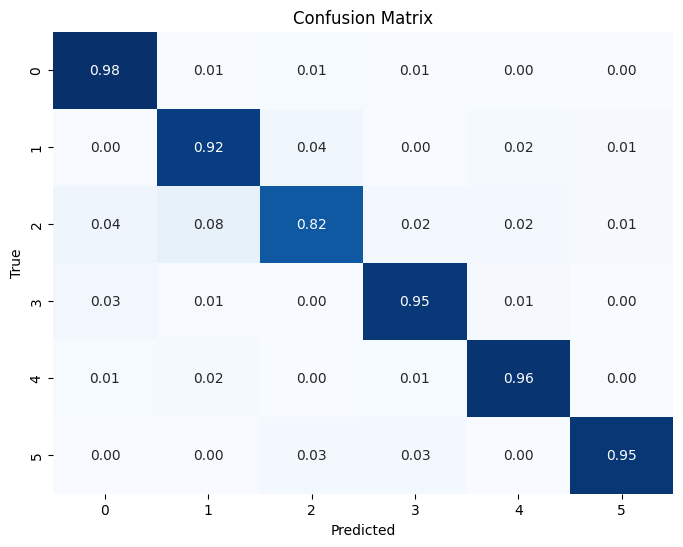


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       187
           1       0.92      0.92      0.92       217
           2       0.91      0.82      0.86       141
           3       0.95      0.95      0.95       146
           4       0.96      0.96      0.96       235
           5       0.86      0.95      0.90        40

    accuracy                           0.93       966
   macro avg       0.92      0.93      0.93       966
weighted avg       0.93      0.93      0.93       966


F1 Score: 0.93


In [ ]:
hold_out_model.predict(test_data=test_dataset, batch_size=32)

In [ ]:
# Training with K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0.0
all_accuracies = list()

start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold+1}/{kf.get_n_splits()}")

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=16,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
    )

    val_loader = DataLoader(
        dataset=train_dataset,
        batch_size=16,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx)
    )

    # Start the model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    num_classes = len(label_encoder.classes_)
    model.fc = nn.Sequential(
      nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )

    k_model = ModelTrainer(
    model=model,
    learning_rate=0.001,
    num_epochs=15,
    weight_decay=0.0001,
    patience=4
    )

    k_model.fit(train_loader=train_loader, val_loader=val_loader, batch_size=32)
    all_accuracies.extend(k_model.accuracy_list)

    # keep the best model
    fold_accuracy = k_model.accuracy_list[-1]
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        best_model = k_model

mean_accuracy = np.mean(all_accuracies)
print(f"Average Accuracy Across Folds: {mean_accuracy:.2f}%")

end_time = time.time()
elapsed_time = end_time - start_time
minutes = elapsed_time // 60
seconds = elapsed_time % 60
print(f"\nTotal training period: {int(minutes)} minutes and {seconds:.2f} seconds\n")

Fold 1/5
Epoch [1/15], Loss: 1.1097, Accuracy: 60.18%
Val Loss: 4.3439, Val Accuracy: 62.81%

Learning rate: [0.001]

Epoch [2/15], Loss: 0.8664, Accuracy: 68.56%
Val Loss: 0.7916, Val Accuracy: 74.12%

Learning rate: [0.001]

Epoch [3/15], Loss: 0.7490, Accuracy: 73.02%
Val Loss: 1.2497, Val Accuracy: 68.01%

Learning rate: [0.001]

Epoch [4/15], Loss: 0.6547, Accuracy: 76.30%
Val Loss: 1.3634, Val Accuracy: 63.59%

Learning rate: [0.001]

Epoch [5/15], Loss: 0.6344, Accuracy: 77.05%
Val Loss: 1.4285, Val Accuracy: 64.50%

Learning rate: [0.0001]

Epoch [6/15], Loss: 0.4626, Accuracy: 84.40%
Val Loss: 0.4877, Val Accuracy: 82.83%

Learning rate: [0.0001]

Epoch [7/15], Loss: 0.3732, Accuracy: 86.54%
Val Loss: 0.3227, Val Accuracy: 87.52%

Learning rate: [0.0001]

Epoch [8/15], Loss: 0.3219, Accuracy: 88.82%
Val Loss: 0.3196, Val Accuracy: 87.26%

Learning rate: [0.0001]

Epoch [9/15], Loss: 0.2822, Accuracy: 89.92%
Val Loss: 0.2948, Val Accuracy: 89.47%

Learning rate: [0.0001]

Epoch


Confusion Matrix:
         battery  glass  metal  paper  plastic  trash
battery      178      4      3      2        0      0
glass          2    193     14      3        4      1
metal          6      8    122      1        2      2
paper          3      1      1    140        1      0
plastic        0      5      2      6      221      1
trash          0      1      0      1        2     36


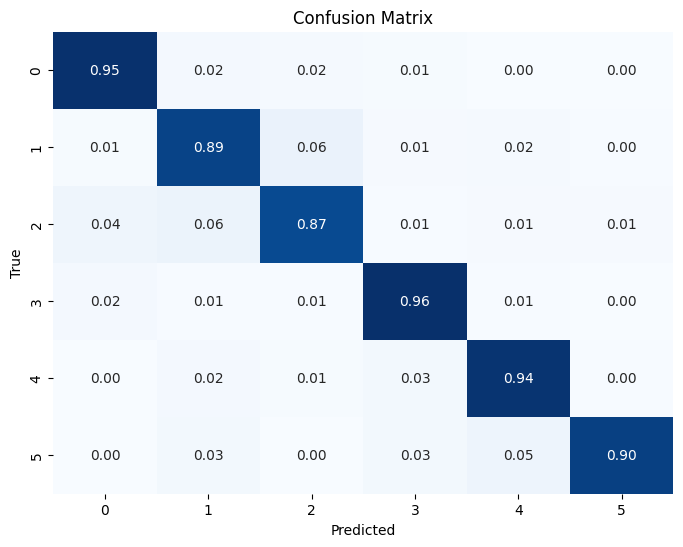


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       187
           1       0.91      0.89      0.90       217
           2       0.86      0.87      0.86       141
           3       0.92      0.96      0.94       146
           4       0.96      0.94      0.95       235
           5       0.90      0.90      0.90        40

    accuracy                           0.92       966
   macro avg       0.91      0.92      0.92       966
weighted avg       0.92      0.92      0.92       966


F1 Score: 0.92


In [ ]:
best_model.predict(test_dataset, batch_size=32)

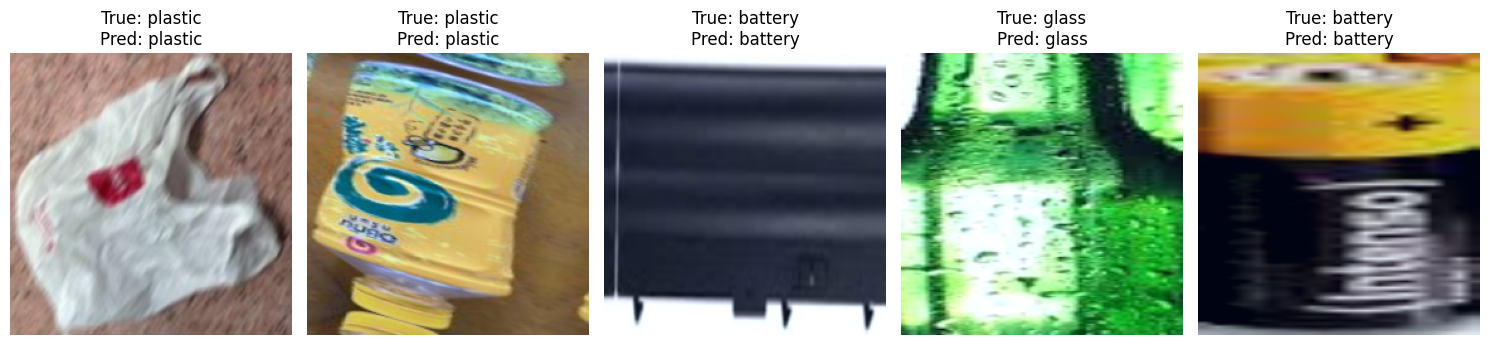

In [ ]:
h_model.eval()
# Take some sample images from test data
num_samples = 5
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
samples = iter(test_loader)
images, labels = next(samples)

# Randomly select 5 examples
random_indices = random.sample(range(len(images)), num_samples)
selected_images = [images[i] for i in random_indices]
selected_labels = [labels[i] for i in random_indices]

# Predict images and labels with model
with torch.no_grad():
    selected_images = torch.stack(selected_images).to("cuda" if torch.cuda.is_available() else "cpu")
    selected_labels = torch.tensor(selected_labels).to("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)

# Analyze labels and predictions
true_labels = label_encoder.inverse_transform(selected_labels.cpu().numpy())
predicted_labels = label_encoder.inverse_transform(predicted.cpu().numpy())

# Print images and predictions on screen
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    ax = axes[i]
    img = selected_images[i].cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy array
    img = np.clip(img * 0.229 + 0.485, 0, 1)  # Undo normalization

    ax.imshow(img)
    ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()